# Deep Architectures for Sampling Molecules

You will use tools from Deeptime (https://deeptime-ml.github.io/) to implement a VAMPNET. You will then train a decoder to generate plausible conformational changes of molecules.

The paper associated with the Deeptime package is: 
Hoffmann, M., Scherer, M.K., Hempel, T., Mardt, A., de Silva, B., Husic, B.E., Klus, S., Wu, H., Kutz, N., Brunton, S.L., & Noé, F. (2021). Deeptime: a Python library for machine learning dynamical models from time series data. Machine Learning: Science and Technology, 3.


## Tutorial 1
### Let us start by getting familiar with Deeptime

To install Deeptime: `pip install deeptime` (see https://deeptime-ml.github.io/latest/index.html).

Let us now generate a simple 2-D time series and extract a 1D compressed signal to learn more on how deeptime's VAMPNET works.

Reference: https://deeptime-ml.github.io/latest/notebooks/vampnets.html


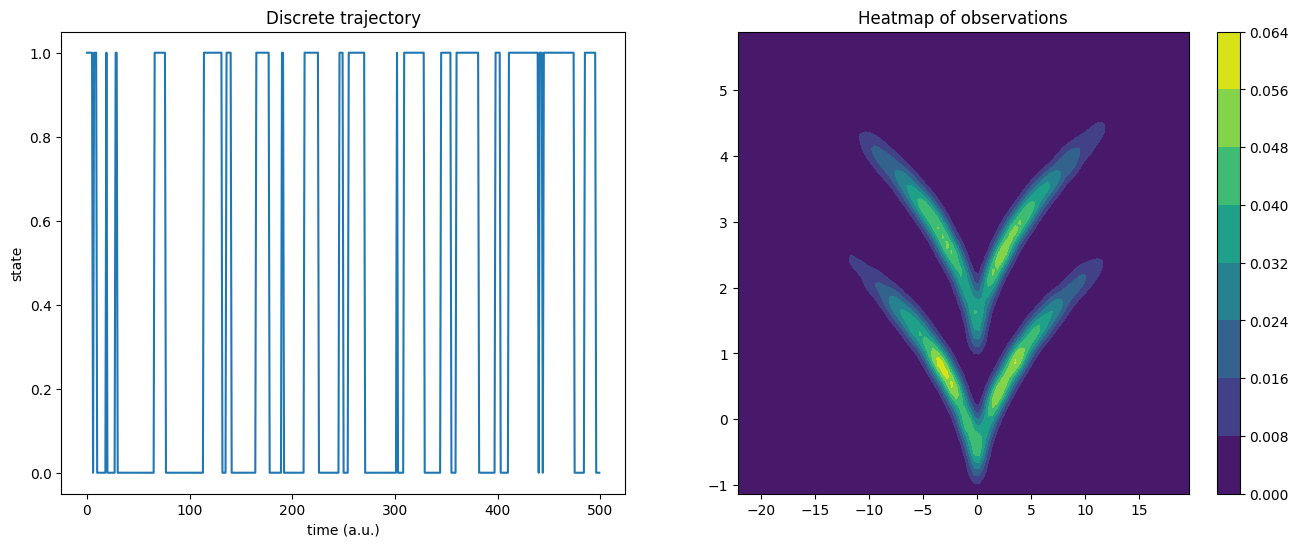

In [14]:
import numpy as np

import torch
import torch.nn as nn

device = 'cpu'
torch.set_num_threads(12)

from deeptime.data import sqrt_model

# The folowing generates samples of states and observations of a HMM (https://deeptime-ml.github.io/latest/api/generated/deeptime.data.sqrt_model.html)
#The hidden variables takes two values 0 or 1 and oberved variable is a vector in 2D.

dtraj, traj = sqrt_model(n_samples=10000)

#The folowing is a plot of the time series
import scipy.stats as stats
import matplotlib.pyplot as plt

X, Y = np.meshgrid(
    np.linspace(np.min(traj[:, 0]), np.max(traj[:, 0]), 100),
    np.linspace(np.min(traj[:, 1]), np.max(traj[:, 1]), 100),
)
kde_input = np.dstack((X, Y)).reshape(-1, 2)

kernel = stats.gaussian_kde(traj.T, bw_method=.1)
Z = kernel(kde_input.T).reshape(X.shape)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(dtraj[:500])
ax1.set_title('Discrete trajectory')
ax1.set_xlabel('time (a.u.)')
ax1.set_ylabel('state')

cm = ax2.contourf(X, Y, Z)
plt.colorbar(cm, ax=ax2);
ax2.set_title('Heatmap of observations');


In [15]:
#In order to work with the VAMPNet / PyTorch API it can be convenient to first convert the trajectory into a time-lagged dataset.

from deeptime.util.data import TrajectoryDataset

dataset = TrajectoryDataset(1, traj.astype(np.float32))


In [16]:
n_val = int(len(dataset)*.3)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])


#The neural network
from deeptime.util.torch import MLP
lobe = MLP(units=[traj.shape[1], 15, 10, 10, 5, 1], nonlinearity=nn.ReLU)
print(lobe)

lobe = lobe.to(device=device)


MLP(
  (_sequential): Sequential(
    (0): Linear(in_features=2, out_features=15, bias=True)
    (1): ReLU()
    (2): Linear(in_features=15, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=5, bias=True)
    (7): ReLU()
    (8): Linear(in_features=5, out_features=1, bias=True)
  )
)


In [17]:
from deeptime.decomposition.deep import VAMPNet

vampnet = VAMPNet(lobe=lobe, learning_rate=1e-4, device=device)

# Dataset train valid

from torch.utils.data import DataLoader

loader_train = DataLoader(train_data, batch_size=512, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)


#Train
from tqdm.notebook import tqdm
model = vampnet.fit(loader_train, n_epochs=160,
                    validation_loader=loader_val, progress=tqdm).fetch_model()


VAMPNet epoch:   0%|          | 0/160 [00:00<?, ?it/s]

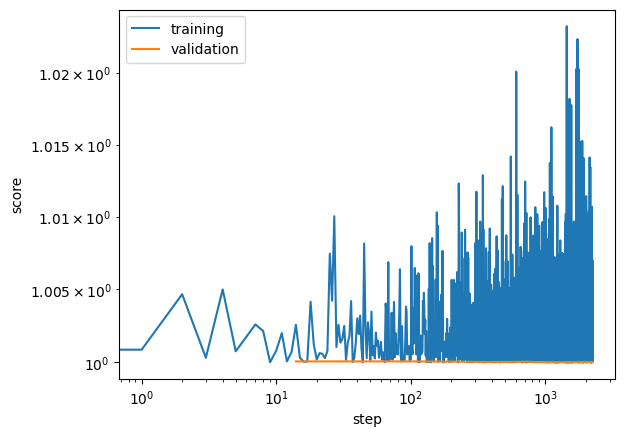

In [18]:
#Plot loss
plt.loglog(*vampnet.train_scores.T, label='training')
plt.loglog(*vampnet.validation_scores.T, label='validation')
plt.xlabel('step')
plt.ylabel('score')
plt.legend();

## Tutorial 2
### Let us see how to learn an MSM
Taken from https://deeptime-ml.github.io/latest/notebooks/mlmsm.html

For a discrete Markov chain $\pi(y \mid x)$, with a finite state space $\Omega$ and finite time steps, the likelihood of a sample trajectory $(x_t, t \leq T)$ is given by,
$$L(\pi)= \prod_{x,y \in \Omega} \pi(y \mid x)^{C_{y,x}}$$

where $C_{y,x}$ is the number of times the transition $x \to y$ happened. One can derive the maximum likelihood estimate analytically. This is what the following function MaximumLikelihoodMSM will be used for.



In [19]:
import deeptime.markov as markov

estimator = markov.msm.MaximumLikelihoodMSM(
    reversible=True,
    stationary_distribution_constraint=None
)


In [21]:
# Generting a Markov chain with three states
import numpy as np

p11 = 0.97
p22 = 0.97
p33 = 0.97
P = np.array([[p11, 1 - p11, 0], [.5*(1 - p22), p22, 0.5*(1-p22)], [0, 1-p33, p33]])
true_msm = markov.msm.MarkovStateModel(P)

# Generating samples of that Markov chain
trajectory = true_msm.simulate(50000)

#Counting the trnaistions
counts_estimator = markov.TransitionCountEstimator(
    lagtime=1, count_mode="sliding"
)
counts = counts_estimator.fit(trajectory).fetch_model()

# The MLE MSM
msm = estimator.fit(counts).fetch_model()

#Printing the learned MSM
print("Estimated transition matrix:", msm.transition_matrix)
print("Estimated stationary distribution:", msm.stationary_distribution)

Estimated transition matrix: [[0.96978394 0.03021606 0.        ]
 [0.01498285 0.96848581 0.01653134]
 [0.         0.02763556 0.97236444]]
Estimated stationary distribution: [0.23679353 0.47754396 0.28566251]


## Exercice 
### VAMPNerts for Alanine Dipeptide

In [2]:
#pip install mdshare
import mdshare

#The time series of Alanine Dipeptide
ala_coords_file = mdshare.fetch("alanine-dipeptide-3x250ns-heavy-atom-positions.npz", working_directory="data")

### Question 1

Learn a VAMPNET on the time series of Alanine Dipeptide. The variable for this VAMPNET will be called "model."

Hint: See [this example](https://deeptime-ml.github.io/latest/notebooks/examples/ala2-example.html).


In [3]:
#Correction

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import mdshare  # for trajectory data
from deeptime.util.torch import MLP
from tqdm.notebook import tqdm  # progress bar

device = 'cpu'
torch.set_num_threads(12)

print(f"Using device {device}")

with np.load(ala_coords_file) as fh:
    data = [fh[f"arr_{i}"].astype(np.float32) for i in range(3)]

from deeptime.util.data import TrajectoryDataset, TrajectoriesDataset

dataset = TrajectoriesDataset.from_numpy(1, data)

n_val = int(len(dataset)*.1)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])

lobe = nn.Sequential(
    nn.BatchNorm1d(data[0].shape[1]),
    nn.Linear(data[0].shape[1], 20), nn.ELU(),
    nn.Linear(20, 20), nn.ELU(),
    nn.Linear(20, 20), nn.ELU(),
    nn.Linear(20, 20), nn.ELU(),
    nn.Linear(20, 20), nn.ELU(),
    nn.Linear(20, 6),
    nn.Softmax(dim=1)  # obtain fuzzy probability distribution over output states
)

lobe = lobe.to(device=device)
print(lobe)

from deeptime.decomposition.deep import VAMPNet

vampnet = VAMPNet(lobe=lobe, learning_rate=5e-3, device=device)

from torch.utils.data import DataLoader

loader_train = DataLoader(train_data, batch_size=10000, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)


Using device cpu
Sequential(
  (0): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=30, out_features=20, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=20, out_features=20, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=20, out_features=20, bias=True)
  (6): ELU(alpha=1.0)
  (7): Linear(in_features=20, out_features=20, bias=True)
  (8): ELU(alpha=1.0)
  (9): Linear(in_features=20, out_features=20, bias=True)
  (10): ELU(alpha=1.0)
  (11): Linear(in_features=20, out_features=6, bias=True)
  (12): Softmax(dim=1)
)


VAMPNet epoch:   0%|          | 0/30 [00:00<?, ?it/s]

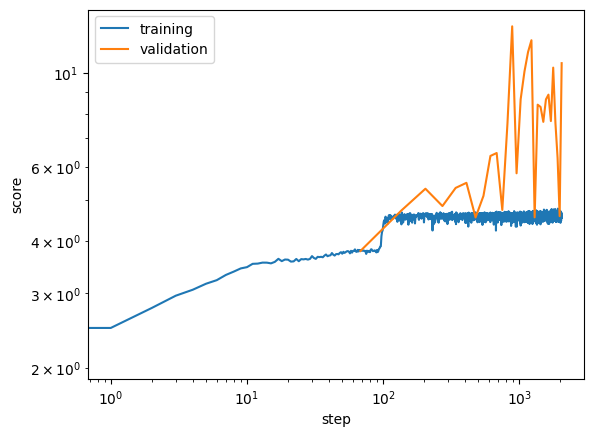

In [27]:
nepochs=30
model = vampnet.fit(loader_train, n_epochs=nepochs,
                    validation_loader=loader_val, progress=tqdm).fetch_model()
plt.loglog(*vampnet.train_scores.T, label='training')
plt.loglog(*vampnet.validation_scores.T, label='validation')
plt.xlabel('step')
plt.ylabel('score')
plt.legend();


### Question 2

The VAMPNET compresses the time series, it plays the role of an encoder; the output of the VAMPNET plays the role of a 'latent space.'

2.1) Cluster the compressed time series dataset.

Hint: The compressed dataset is the collection of compressed configurations $model(x_t)$


In [38]:
#Correction
from deeptime.clustering import KMeans



projections = [model(traj) for traj in data]
cluster = KMeans(4, progress=tqdm).fit_fetch(projections)
dtrajs = [cluster.transform(x) for x in projections]


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

(250000,)


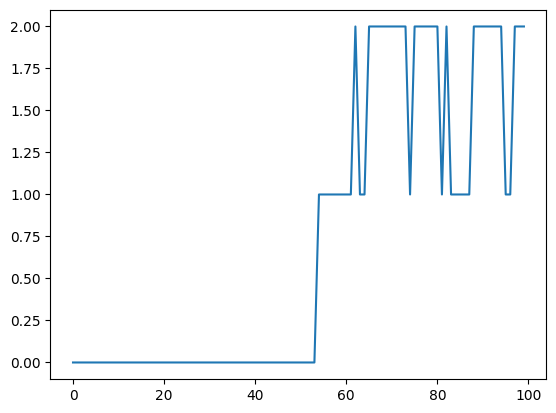

In [89]:
fig, ax = plt.subplots()

print(dtrajs[0].shape)
ax.plot(dtrajs[0][:100])

(250000, 30)
(250000, 6)


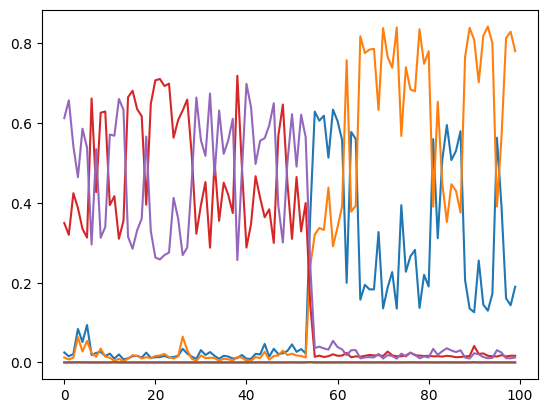

In [59]:
print(data[0].shape)
print(projections[0].shape)

fig, ax = plt.subplots()

# print(projections[0].shape)

ax.plot(projections[0][:100, :]);

(249998, 30)
(249998, 30)


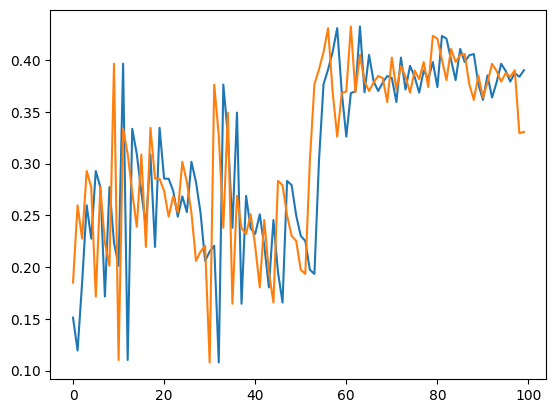

In [77]:
xp = TrajectoryDataset(2, data[0])

fig, ax = plt.subplots()
# ax.plot(data[0][:100, 0])
ax.plot(xp.data[:100, 0])
ax.plot(xp.data_lagged[:100, 0])
print(xp.data.shape)
print(xp.data_lagged.shape)


### Question 3

3.1) Learn an MSM from the clustering on the compressed dataset.

3.2) Generate samples from this learned discrete Markov chain.

Hint: Refer to tutorial 2.


In [93]:
from deeptime.markov import TransitionCountEstimator
import deeptime.markov as markov
estimator = markov.msm.MaximumLikelihoodMSM(
    reversible=True,
    stationary_distribution_constraint=None
)


counts_estimator = markov.TransitionCountEstimator(
    lagtime=1, count_mode="sliding"
)
counts = counts_estimator.fit(dtrajs).fetch_model()

# The MLE MSM
msm = estimator.fit(counts).fetch_model()

import random

#generating novel trajectories
matrix=msm.transition_matrix
sample=[0]
state=0
for i in range(100):
    rand=random.uniform(0, 1)
    count=0
    stp=1
    for j in range(matrix.shape[1]):
        if count+matrix[state][j]>rand and stp:
            state=j
            stp=0
        count+=matrix[state][j]
    sample.append(state)


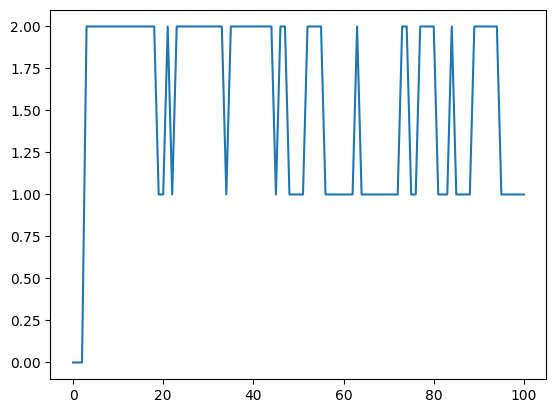

In [94]:
# counts.count_matrix
fig, ax = plt.subplots()

ax.plot(sample)

### Question 4
4.1) Freeze the weights of the encoder and learn a decoder to generate configurations of Alanine Dipeptide from the clusters.

4.2) Generate samples of the time evolution of Alanine Dipeptide from this learned discrete Markov chain.

Hint: Freeze the weights of the VAMPNET, define a neural network that will serve as the decoder. The full network is Decoder + Encoder with frozen weights. Train the autoencoder with the Mean Square Error and use gradient descent for training.


In [95]:
encoder=model.lobe
shape_in=cluster.cluster_centers.shape[1]

#For example:
decoder = MLP(units=[shape_in, 10, 15, 15, data[0].shape[1]], nonlinearity=nn.ReLU)

In [96]:
for param in encoder.parameters():
    param.requires_grad = False

class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = encoder
        self.decoder = decoder


    def forward(self, x):
        x = self.decoder(self.encoder(x))
        return x
autoenc=AutoEncoder()

In [97]:
training_loader = torch.utils.data.DataLoader(train_data, batch_size=30, shuffle=True)
optimizer = torch.optim.SGD(autoenc.parameters(), lr=0.001, momentum=0.9)
criterion = torch.nn.MSELoss()
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, datas in enumerate(training_loader, 0):

        inputs, input_lag = datas #only keep inputs without lag

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs =autoenc(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0


[1,  2000] loss: 0.271
[1,  4000] loss: 0.003
[1,  6000] loss: 0.002
[1,  8000] loss: 0.002
[1, 10000] loss: 0.002
[1, 12000] loss: 0.002
[1, 14000] loss: 0.002
[1, 16000] loss: 0.002
[1, 18000] loss: 0.002
[1, 20000] loss: 0.002
[1, 22000] loss: 0.002
[2,  2000] loss: 0.002
[2,  4000] loss: 0.002
[2,  6000] loss: 0.002
[2,  8000] loss: 0.002
[2, 10000] loss: 0.002
[2, 12000] loss: 0.001
[2, 14000] loss: 0.001
[2, 16000] loss: 0.001
[2, 18000] loss: 0.001
[2, 20000] loss: 0.001
[2, 22000] loss: 0.001


In [98]:
autoenc.decoder(torch.tensor(cluster.cluster_centers).float())

tensor([[ 3.0592e-01,  2.6543e+00,  2.0641e-01,  2.8150e-01,  2.5560e+00,
          1.2411e-01,  1.8505e-01,  2.5908e+00,  7.3805e-02,  2.6175e-01,
          2.5030e+00,  1.0944e-01,  2.7108e-01,  2.3773e+00,  3.0420e-02,
          3.9430e-01,  2.3357e+00, -1.0192e-02,  1.9135e-01,  2.2659e+00,
          7.6577e-02,  1.7499e-01,  2.1775e+00,  1.9915e-02,  1.0358e-01,
          2.2589e+00,  6.7078e-02, -2.2929e-02,  2.1599e+00,  9.3337e-02],
        [ 3.4430e-01,  2.6660e+00,  2.0957e-01,  2.6882e-01,  2.5883e+00,
          1.2389e-01,  1.7871e-01,  2.6299e+00,  9.4468e-02,  3.2252e-01,
          2.4471e+00,  7.4183e-02,  2.4294e-01,  2.3754e+00, -1.1608e-02,
          3.1026e-01,  2.3308e+00, -1.1417e-01,  1.6412e-01,  2.2516e+00,
          3.2448e-02,  2.2902e-01,  2.2002e+00,  1.1783e-01,  4.9650e-02,
          2.2191e+00,  3.7065e-02, -6.4009e-03,  2.1000e+00,  8.7285e-02],
        [ 3.6199e-01,  2.6519e+00,  2.0163e-01,  2.5604e-01,  2.5863e+00,
          1.1763e-01,  1.8062e-01,  